# Set up

In [7]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result
from model.PlotManager import PlotManager

In [8]:
#Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) #kgm2
hull_surface_area = .0383 #m2
hull_frontal_area = 0.0088
hull_cd = 1.2
hull_corr_factor = 0.75
hull_chord = .215

r_xi = -111.76 * 10 ** (-3) #m 
r_zi = 0.722 * 10 ** (-3) #m

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10**(-3)
r_zt = -75 * 10**(-3)

# Aero foil parameters
ctrl_AR = 2.61 #aspect ratio
ctrl_area = 0.025 #planform area
ctrl_stall_threshold = 10 #Angle of attack stall threshold
ctrl_Cl_a = 0.1/np.deg2rad(1)
ctrl_Cl_alpha_offset = 0.5
ctrl_chord = 0.1

#Towing parameters
tow_magnitude = 10 #N gets overritten by equilibrium optimization
drone_height = 3 #m above water
drone_tow_length = 5 #m 
probe_depth = 0.3

In [9]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]), tow_magnitude, drone_height, drone_tow_length, probe_depth)
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5), ctrl_AR, ctrl_area, ctrl_chord, ctrl_stall_threshold, ctrl_Cl_a, ctrl_Cl_alpha_offset)
hullForce = HullForce(np.array([r_xh,r_zh]), hull_surface_area, hull_frontal_area, hull_chord, hull_cd, hull_corr_factor)

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])

plot = PlotManager()

In [10]:
# Define range of delta_i values and velocity range
delta_i_values = np.deg2rad(np.linspace(-5, -5, 1))  # Different fixed delta_i values in degrees
velocities = np.linspace(0.5, 8.0, 20)  # Adjust velocity range as needed

# Storage for results
results = {delta_i: {'pitch_angles': [], 'delta_ts': [], 'towing_forces': [], 'Cost' : []} for delta_i in delta_i_values}

for delta_i in delta_i_values:
    # Set fixed delta_i for control force
    sim.controlForces[0].delta_i = delta_i
    sim.lb_delta_i = delta_i
    sim.ub_delta_i = delta_i + 1e-6

    # Loop over velocities
    for vel in velocities:
        # Solve equilibrium state at each velocity
        result, cost = sim.solve_equilibrium_state_LS_Vel(vel, print_results=0)
        
        # Store results
        results[delta_i]['pitch_angles'].append(np.rad2deg(result[0]))  # Pitch angle in degrees
        results[delta_i]['delta_ts'].append(np.rad2deg(result[1]))      # Delta_t in degrees
        results[delta_i]['towing_forces'].append(result[2])             # Towing force in N
        results[delta_i]['Cost'].append(cost)


## Plot Results

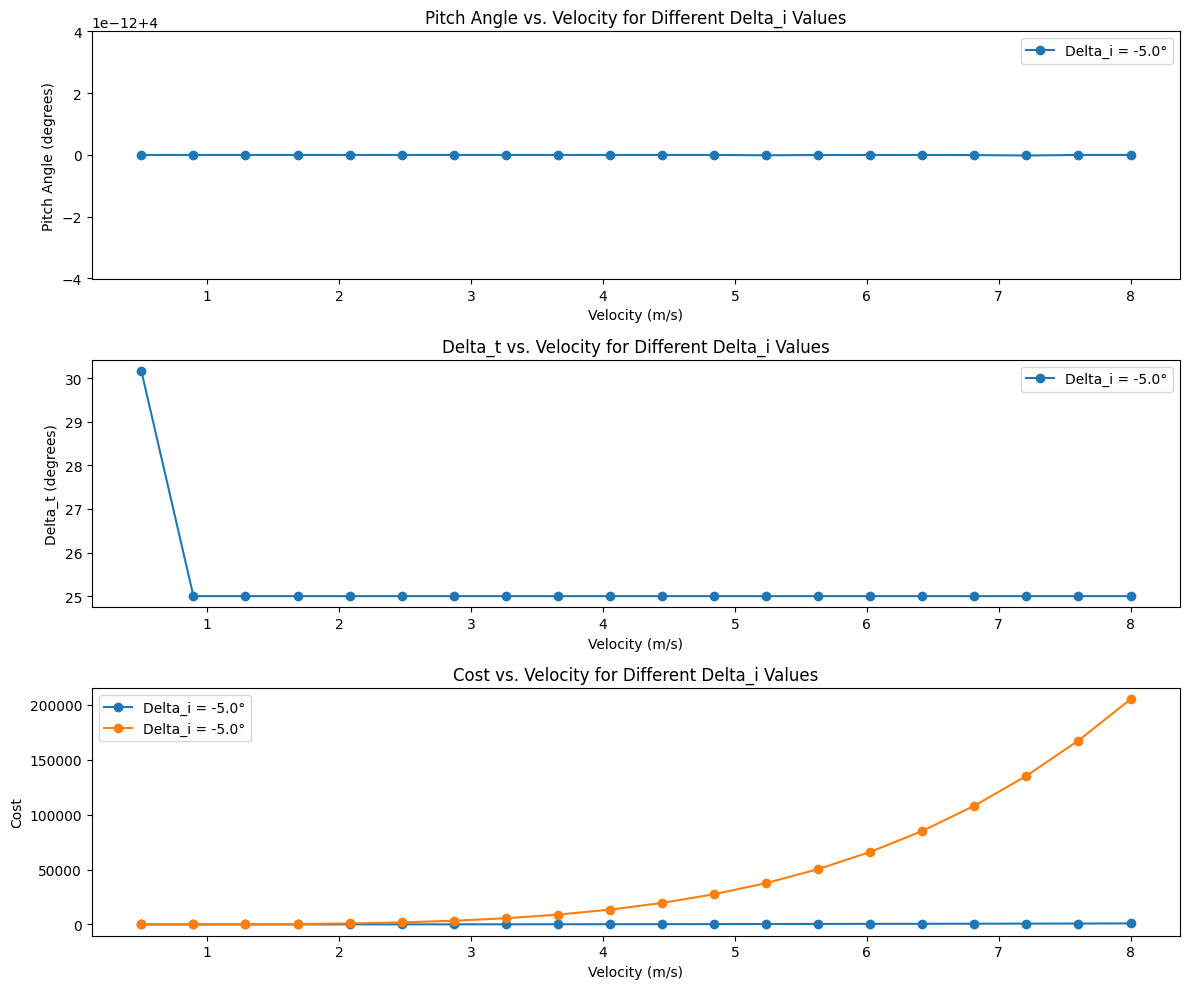

In [11]:
plt.figure(figsize=(12, 10))

# Plot Pitch Angle vs. Velocity for each delta_i
plt.subplot(3, 1, 1)
for delta_i, data in results.items():
    plt.plot(velocities, data['pitch_angles'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Pitch Angle vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Pitch Angle (degrees)")
plt.legend()

# Plot Delta_t vs. Velocity for each delta_i
plt.subplot(3, 1, 2)
for delta_i, data in results.items():
    plt.plot(velocities, data['delta_ts'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Delta_t vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Delta_t (degrees)")
plt.legend()

# Plot Towing Force vs. Velocity for each delta_i
plt.subplot(3, 1, 3)
for delta_i, data in results.items():
    plt.plot(velocities, data['towing_forces'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Towing Force vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Towing Force (N)")
plt.legend()

# Plot Cost vs. Velocity for each delta_i
plt.subplot(3, 1, 3)
for delta_i, data in results.items():
    plt.plot(velocities, data['Cost'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Cost vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Cost")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Define range of delta_i values and velocity range
delta_i_values = np.deg2rad(np.linspace(-5, 5, 10))  # Different fixed delta_i values in degrees
velocities = np.linspace(0.5, 8.0, 20)  # Adjust velocity range as needed

# Storage for results
results = {delta_i: {'pitch_angles': [], 'delta_ts': [], 'towing_forces': [], 'cost': []} for delta_i in delta_i_values}

for delta_i in delta_i_values:
    # Set fixed delta_i for control force
    sim.controlForces[0].delta_i = delta_i
    sim.lb_delta_i = delta_i
    sim.ub_delta_i = delta_i + 1e-6

    # Loop over velocities
    for vel in velocities:
        # Solve equilibrium state at each velocity
        result, cost = sim.solve_equilibrium_state_LS(vel, print_results=0)
        
        # Store results
        results[delta_i]['pitch_angles'].append(np.rad2deg(result[0]))  # Pitch angle in degrees
        results[delta_i]['delta_ts'].append(np.rad2deg(result[1]))      # Delta_t in degrees
        results[delta_i]['towing_forces'].append(result[2])             # Towing force in N
        results[delta_i]['cost'].append(cost)


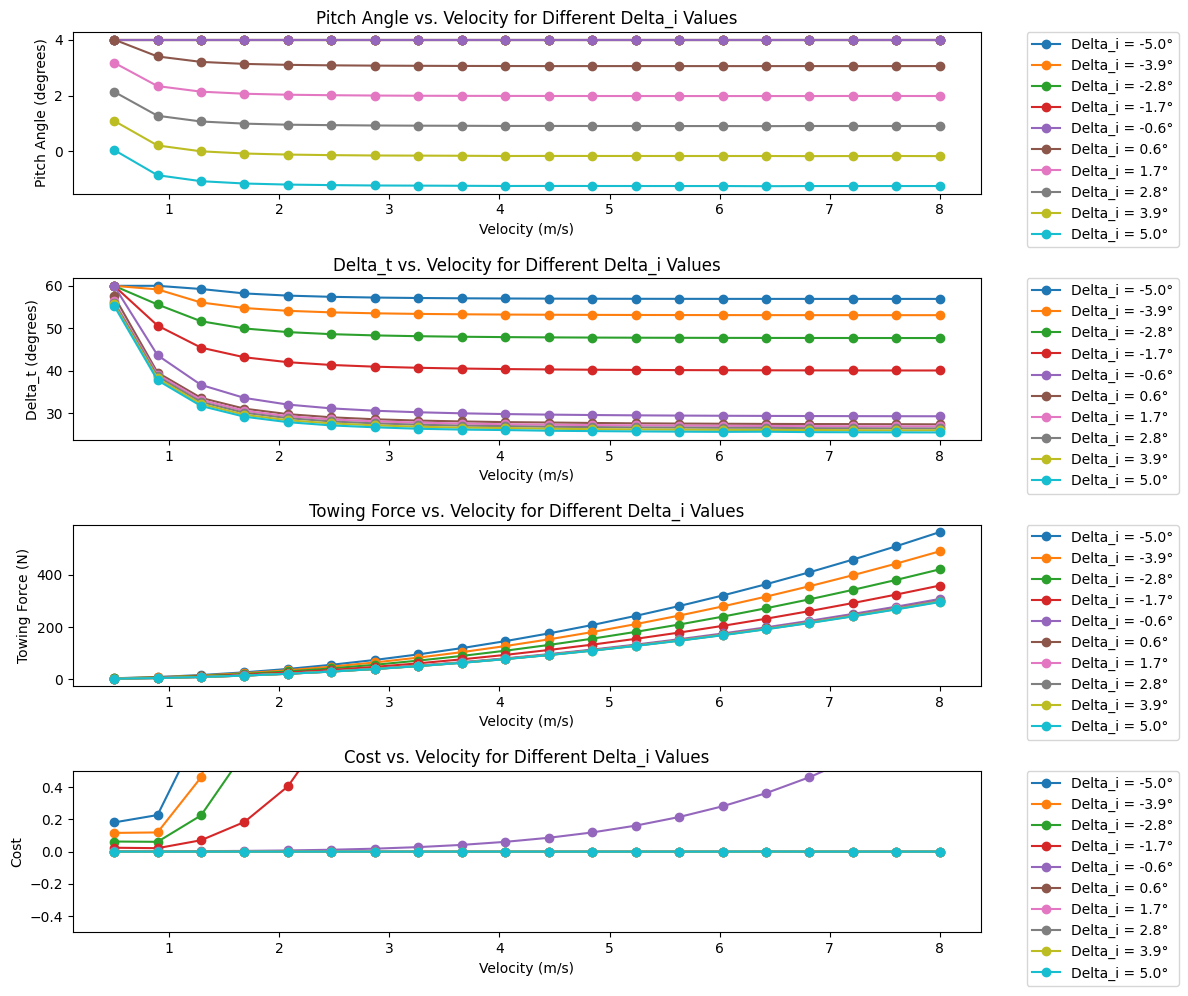

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=(12, 10))

# Plot Pitch Angle vs. Velocity for each delta_i
plt.subplot(4, 1, 1)
for delta_i, data in results.items():
    plt.plot(velocities, data['pitch_angles'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Pitch Angle vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Pitch Angle (degrees)")
# plt.ylim([-2.1, -1.9])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot Delta_t vs. Velocity for each delta_i
plt.subplot(4, 1, 2)
for delta_i, data in results.items():
    plt.plot(velocities, data['delta_ts'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Delta_t vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Delta_t (degrees)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot Towing Force vs. Velocity for each delta_i
plt.subplot(4, 1, 3)
for delta_i, data in results.items():
    plt.plot(velocities, data['towing_forces'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Towing Force vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Towing Force (N)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# Plot Cost vs. Velocity for each delta_i
plt.subplot(4, 1, 4)
for delta_i, data in results.items():
    plt.plot(velocities, data['cost'], marker='o', label=f"Delta_i = {np.rad2deg(delta_i):.1f}°")
plt.title("Cost vs. Velocity for Different Delta_i Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Cost")
plt.ylim([-0.5, 0.5])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()